In [ ]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install timm

Using device: cuda
Starting training...

Epoch 1
----------------------------
loss: 1.007546 [  320/  986]
loss: 0.708381 [  640/  986]
loss: 0.708157 [  960/  986]
Train Loss: 0.9600
Validation Loss: 0.8075	 Validation Accuracy: 56.00

Epoch 2
----------------------------
loss: 0.733338 [  320/  986]
loss: 0.811611 [  640/  986]
loss: 0.759198 [  960/  986]
Train Loss: 0.7459
Validation Loss: 0.7727	 Validation Accuracy: 44.00

Epoch 3
----------------------------
loss: 0.713334 [  320/  986]
loss: 0.687472 [  640/  986]
loss: 0.687633 [  960/  986]
Train Loss: 0.6960
Validation Loss: 0.6883	 Validation Accuracy: 55.43

Epoch 4
----------------------------
loss: 0.689503 [  320/  986]
loss: 0.706635 [  640/  986]
loss: 0.679925 [  960/  986]
Train Loss: 0.6872
Validation Loss: 0.7054	 Validation Accuracy: 43.43

Epoch 5
----------------------------
loss: 0.703767 [  320/  986]
loss: 0.677512 [  640/  986]
loss: 0.689356 [  960/  986]
Train Loss: 0.6805
Validation Loss: 0.6980	 Validat

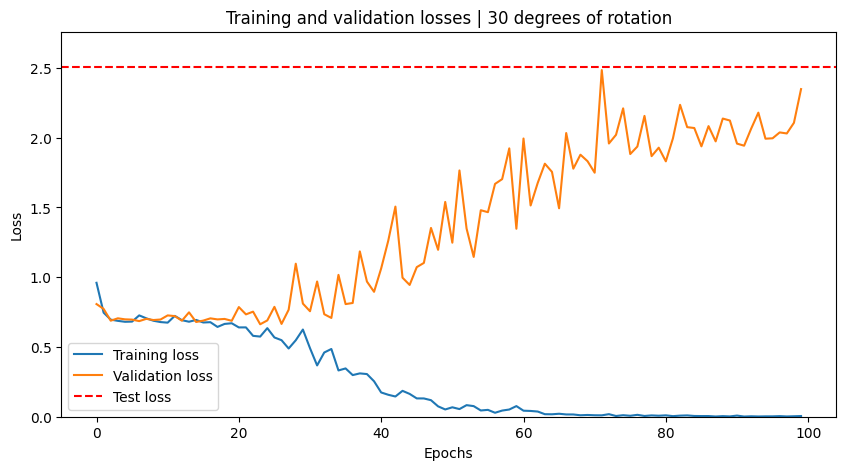

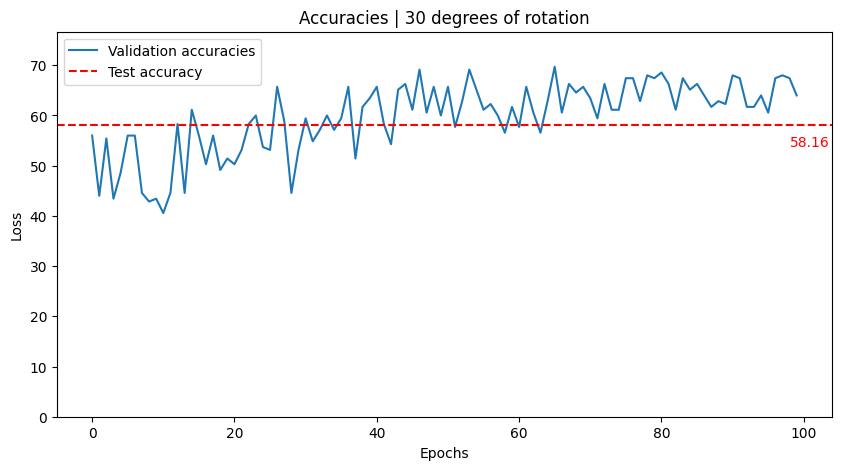

In [ ]:
# -*- coding: utf-8 -*-

# Training part

import timm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import logging
import numpy as np
import random
import pickle
from torcheval.metrics import BinaryAccuracy
import matplotlib.pyplot as plt
from torch import float32


num_classes = 1  # doing this for binary classification
lr = 0.0001
n_epochs = 100
batch_size = 64
batch_size_test = 64
RANDOM_SEED = 1839
pretrained = True
model_name = 'resnetv2_50x1_bit.goog_in21k'

dataset_path = "./drive/MyDrive/CS163/Egg_Sex/egg_sex/larger_test_set/HH19_256"
train_set_path = os.path.join(dataset_path, 'training')
validation_set_path = os.path.join(dataset_path, 'validation')
test_set_path = os.path.join(dataset_path, 'testing')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device: {device}')


# configure dataset
class CustomDataset(Dataset):
    def __init__(self, pickle_dir):
        self.pickle_files = [f for f in os.listdir(pickle_dir) if f.endswith('pickle') and not f.startswith('.')]
        self.data = []
        self.transform = transforms.Compose([
            transforms.RandomAffine(degrees=30, translate=(0.05, 0.05)),
            transforms.ToTensor(),  # doing this because it wasn't done when creating pickle files
            transforms.Normalize(mean=[0.449], std=[0.226])  # avg of values for imagenet
        ])

        for pickle_file in self.pickle_files:
            with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
                self.data.extend(pickle.load(f))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data[index]
        image = data_point['image']
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(float(data_point['label']), dtype=float32)
        additional_info = data_point['additional_info']
        return image, label, additional_info


# This one doesn't have data augmentation, has the same normalization as CustomDataset
class CustomDatasetTest(Dataset):
    def __init__(self, pickle_dir):
        self.pickle_files = [f for f in os.listdir(pickle_dir) if f.endswith('pickle') and not f.startswith('.')]
        self.data = []
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # doing this because it wasn't done when creating pickle files
            transforms.Normalize(mean=[0.449], std=[0.226])  # avg of values for imagenet

        ])

        for pickle_file in self.pickle_files:
            with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
                self.data.extend(pickle.load(f))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data[index]
        image = data_point['image']
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(float(data_point['label']), dtype=float32)
        additional_info = data_point['additional_info']
        return image, label, additional_info


def create_grayscale_model(model_name, pretrained=True, num_classes=1):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

    if hasattr(model, 'stem'):
        first_conv_layer = model.stem[0]

        # new Conv2d layer with 1 input channel for grayscale
        new_first_conv = nn.Conv2d(
            in_channels=1,
            out_channels=first_conv_layer.out_channels,
            kernel_size=first_conv_layer.kernel_size,
            stride=first_conv_layer.stride,
            padding=first_conv_layer.padding,
            bias=first_conv_layer.bias is not None
        )

        # Copy pretrained weights by averaging over the RGB channels
        with torch.no_grad():
            new_first_conv.weight[:] = first_conv_layer.weight.mean(dim=1, keepdim=True)

        # Replace the first convolutional layer in the stem
        model.stem[0] = new_first_conv

    elif hasattr(model, 'conv1'):
        first_conv_layer = model.conv1
        new_first_conv = nn.Conv2d(
            in_channels=1,  # Change to 1 for grayscale
            out_channels=first_conv_layer.out_channels,
            kernel_size=first_conv_layer.kernel_size,
            stride=first_conv_layer.stride,
            padding=first_conv_layer.padding,
            bias=first_conv_layer.bias is not None
        )

        with torch.no_grad():
            new_first_conv.weight[:] = first_conv_layer.weight.mean(dim=1, keepdim=True)

        model.conv1 = new_first_conv

    return model


def set_seed(RANDOM_SEED):
    torch.manual_seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(RANDOM_SEED)
        torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


set_seed(RANDOM_SEED)

# create model and dataset, dataloader
# model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes).to(device)
model = create_grayscale_model(model_name, pretrained=pretrained, num_classes=num_classes).to(device)


dataset_train = CustomDataset(train_set_path)
train_size = int(0.85 * len(dataset_train))
validation_size =  len(dataset_train) - train_size
dataset_train, dataset_validation = torch.utils.data.random_split(dataset_train, [train_size, validation_size])

dataset_test = CustomDatasetTest(test_set_path)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_validation = DataLoader(dataset_validation, batch_size=batch_size_test, shuffle=False, drop_last=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, drop_last=False)


# train and test functions
def train(dataloader_train, model, loss_fn, optimizer, device):
    model.train()

    size_of_dataset = len(dataloader_train.dataset)

    running_loss = 0.0
    for batch_id, (images, labels, additional_info) in enumerate(dataloader_train):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        predictions = model(images).sigmoid().squeeze(1)
        loss = loss_fn(predictions, labels)  # could make predictions to be probabilities as well
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_id + 1) % 5 == 0:
            images_completed = (batch_id + 1) * len(images)
            print(f'loss: {loss.item():.6f} [{images_completed:>5d}/{size_of_dataset:>5d}]')

    loss_of_epoch = running_loss / len(dataloader_train)
    print(f'Train Loss: {loss_of_epoch:.4f}')
    return loss_of_epoch


def validate(dataloader_validation, model, loss_fn, device):
    model.eval()

    running_loss = 0.0
    metric = BinaryAccuracy(threshold=0.5)
    with torch.no_grad():
        for batch_id, (images, labels, additional_info) in enumerate(dataloader_validation):
            images, labels = images.to(device), labels.to(device)

            prediction = model(images).sigmoid().squeeze(1)
            loss = loss_fn(prediction, labels)  # could make predictions to be probabilities as well

            running_loss += loss.item()

            metric.update(prediction, labels)

    loss_of_epoch = running_loss / len(dataloader_validation)
    accuracy = 100. * metric.compute().item()
    print(f'Validation Loss: {loss_of_epoch:.4f}\t Validation Accuracy: {accuracy:.2f}')
    return loss_of_epoch, accuracy


# optimizer, loss_fn, learning rate scheduler
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

# training loop
print("Starting training...")

losses = list()
losses_validation = list()
accuracies_validation = list()

losses_test = list()
accuracies_test = list()
for epoch in range(n_epochs):
    print(f'\nEpoch {epoch+1}\n{"-"*28}')

    loss = train(dataloader_train, model, loss_fn, optimizer, device)
    loss_validation, accuracy_validation = validate(dataloader_validation, model, loss_fn, device)

    losses.append(loss)
    losses_validation.append(loss_validation)
    accuracies_validation.append(accuracy_validation)

    scheduler.step()

print("\n\n\nStarting testing on the test set:")
loss_test, accuracy_test = validate(dataloader_test, model, loss_fn, device)

plot_dir = './'

losses_ymax = max(losses + losses_validation + [loss_test]) * 1.1

plt.figure(figsize=(10, 5))
plt.title("Training and validation losses | 30 degrees of rotation")
plt.plot(losses, label="Training loss")
plt.plot(losses_validation, label="Validation loss")
plt.ylim(ymin=0)
plt.axhline(y=loss_test, color='r', linestyle='--', label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(ymax=losses_ymax)
plt.legend()
plt.savefig(os.path.join(plot_dir, f'losses_256.png'))

accuracies_ymax = max(accuracies_validation + [accuracy_test]) * 1.1

plt.figure(figsize=(10, 5))
plt.title("Accuracies | 30 degrees of rotation")
plt.plot(accuracies_validation, label="Validation accuracies")
plt.ylim(ymin=0)
plt.axhline(y=accuracy_test, color='r', linestyle='--', label="Test accuracy")
plt.text(
    x=len(accuracies_validation) - 2,  # Place near the end of the x-axis
    y=accuracy_test - 5,  # Align with the horizontal line
    s=f'{accuracy_test:.2f}',  # Format the value to 2 decimal places
    color='red',
    fontsize=10,
    verticalalignment='bottom'  # Position text slightly below the line
)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(ymax=accuracies_ymax)
plt.legend()
plt.savefig(os.path.join(plot_dir, f'accuracies_256.png'))



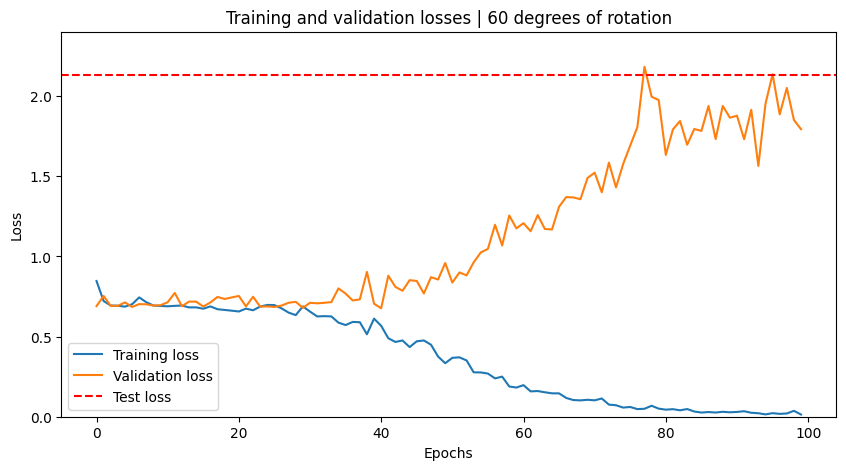

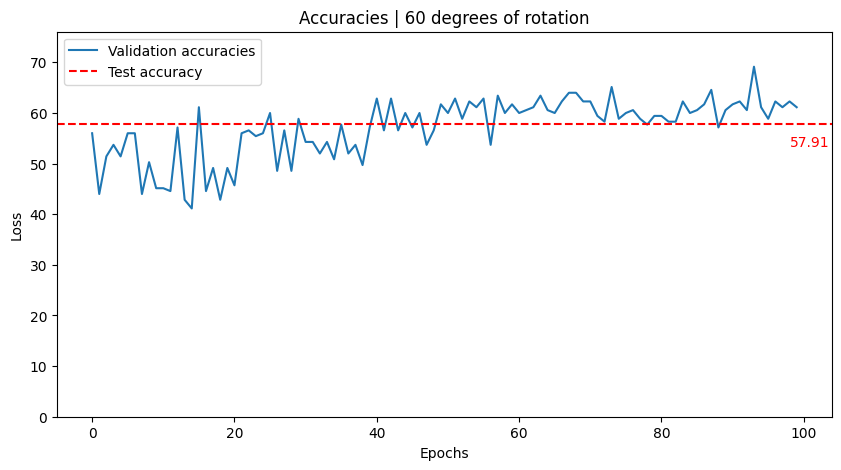

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Training and validation losses | 60 degrees of rotation")
plt.plot(losses, label="Training loss")
plt.plot(losses_validation, label="Validation loss")
plt.ylim(ymin=0)
plt.axhline(y=loss_test, color='r', linestyle='--', label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(ymax=losses_ymax)
plt.legend()
plt.savefig(os.path.join(plot_dir, f'losses_256.png'))

accuracies_ymax = max(accuracies_validation + [accuracy_test]) * 1.1

plt.figure(figsize=(10, 5))
plt.title("Accuracies | 60 degrees of rotation")
plt.plot(accuracies_validation, label="Validation accuracies")
plt.ylim(ymin=0)
plt.axhline(y=accuracy_test, color='r', linestyle='--', label="Test accuracy")
plt.text(
    x=len(accuracies_validation) - 2,  # Place near the end of the x-axis
    y=accuracy_test - 5,  # Align with the horizontal line
    s=f'{accuracy_test:.2f}',  # Format the value to 2 decimal places
    color='red',
    fontsize=10,
    verticalalignment='bottom'  # Position text slightly below the line
)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(ymax=accuracies_ymax)
plt.legend()
plt.savefig(os.path.join(plot_dir, f'accuracies_256.png'))

In [ ]:
!ls ./

drive	     Training_accuracies_256.png  yolov7	   yolov7.pt
sample_data  Training_losses_256.png	  yolov7-main.zip


In [ ]:
# -*- coding: utf-8 -*-

# Training part

import timm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import logging
import numpy as np
import random
import pickle
from torcheval.metrics import BinaryAccuracy
import matplotlib.pyplot as plt
from torch import float32

import sys
sys.path.append('/content/yolov7-main')
from models.experimental import attempt_load
from utils.torch_utils import select_device


num_classes = 1  # doing this for binary classification
lr = 0.0001
n_epochs = 20
batch_size = 64
batch_size_test = 64
RANDOM_SEED = 1839
pretrained = True
model_name = 'resnetv2_50x1_bit.goog_in21k'

dataset_path = "./drive/MyDrive/CS163/Egg_Sex/egg_sex/HH19_256"
train_set_path = os.path.join(dataset_path, 'training')
validation_set_path = os.path.join(dataset_path, 'validation')
test_set_path = os.path.join(dataset_path, 'testing')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device: {device}')


# configure dataset
class CustomDataset(Dataset):
    def __init__(self, pickle_dir):
        self.pickle_files = [f for f in os.listdir(pickle_dir) if f.endswith('pickle') and not f.startswith('.')]
        self.data = []
        self.transform = transforms.Compose([
            transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
            transforms.ToTensor(),  # doing this because it wasn't done when creating pickle files
            transforms.Normalize(mean=[0.449], std=[0.226])  # avg of values for imagenet
        ])

        for pickle_file in self.pickle_files:
            with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
                self.data.extend(pickle.load(f))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data[index]
        image = data_point['image']
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(float(data_point['label']), dtype=float32)
        additional_info = data_point['additional_info']
        return image, label, additional_info


# This one doesn't have data augmentation, has the same normalization as CustomDataset
class CustomDatasetTest(Dataset):
    def __init__(self, pickle_dir):
        self.pickle_files = [f for f in os.listdir(pickle_dir) if f.endswith('pickle') and not f.startswith('.')]
        self.data = []
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # doing this because it wasn't done when creating pickle files
            transforms.Normalize(mean=[0.449], std=[0.226])  # avg of values for imagenet

        ])

        for pickle_file in self.pickle_files:
            with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
                self.data.extend(pickle.load(f))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data[index]
        image = data_point['image']
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(float(data_point['label']), dtype=float32)
        additional_info = data_point['additional_info']
        return image, label, additional_info


class YOLOv7GrayscaleClassifier(nn.Module):
    def __init__(self, model_path, num_classes=10):
        super(YOLOv7GrayscaleClassifier, self).__init__()
        # Load YOLOv7 backbone
        #backbone = attempt_load(model_path, map_location='cpu')

        checkpoint = torch.load(model_path, map_location='cpu')
        backbone = checkpoint['model']

        # Modify the first convolution layer for grayscale input
        if hasattr(backbone, 'model') and hasattr(backbone.model[0], 'conv'):
            first_conv_layer = backbone.model[0].conv  # Access the first convolution layer

            # Create a new convolution layer with 1 input channel for grayscale
            new_first_conv = nn.Conv2d(
                in_channels=1,  # Set to 1 for grayscale
                out_channels=first_conv_layer.out_channels,
                kernel_size=first_conv_layer.kernel_size,
                stride=first_conv_layer.stride,
                padding=first_conv_layer.padding,
                bias=first_conv_layer.bias is not None
            )

            # Copy pretrained weights by averaging over RGB channels
            with torch.no_grad():
                new_first_conv.weight[:] = first_conv_layer.weight.mean(dim=1, keepdim=True)

            # Replace the original first convolution layer
            backbone.model[0].conv = new_first_conv

        # Keep the backbone layers only
        self.backbone = nn.Sequential(*list(backbone.model.children())[:-1])

        # Add a classification head
        self.fc = nn.Linear(in_features=1024, out_features=num_classes)  # Adjust in_features if needed

    def forward(self, x):
        x = self.backbone(x)  # Forward through the backbone
        x = torch.flatten(x, 1)  # Flatten the output to feed into the FC layer
        x = self.fc(x)  # Forward through the classification head
        return x


class ModifiedYOLOv7(nn.Module):
    def __init__(self, model_path, num_classes):
        super(ModifiedYOLOv7, self).__init__()
        checkpoint = torch.load(model_path)
        model = checkpoint['model']
        # Modify the first convolutional layer for grayscale input
        first_conv_layer = model.model[0] if hasattr(model, 'model') else model[0]
        self.first_conv = nn.Conv2d(
            in_channels=1,  # Set to 1 for grayscale
            out_channels=first_conv_layer.out_channels,
            kernel_size=first_conv_layer.kernel_size,
            stride=first_conv_layer.stride,
            padding=first_conv_layer.padding,
            bias=first_conv_layer.bias is not None
        )
        # Copy weights from the first three channels and average them
        with torch.no_grad():
            self.first_conv.weight.data = first_conv_layer.weight.data.mean(dim=1, keepdim=True)

        # Replace all other layers except the last
        self.features = nn.Sequential(*list(model.children())[1:-1])

        # Adjust the last layer for the new number of classes
        last_layer = model.model[-1] if hasattr(model, 'model') else model[-1]
        self.last_layer = nn.Linear(
            in_features=last_layer.in_features,  # Assuming it's a linear layer
            out_features=num_classes  # Set to new number of classes
        )

    def forward(self, x):
        x = self.first_conv(x)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.last_layer(x)
        return x


def set_seed(RANDOM_SEED):
    torch.manual_seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(RANDOM_SEED)
        torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


set_seed(RANDOM_SEED)

model = ModifiedYOLOv7('yolov7.pt', num_classes=num_classes).to(device).float()


dataset_train = CustomDataset(train_set_path)
dataset_validation = CustomDatasetTest(validation_set_path)
dataset_test = CustomDatasetTest(test_set_path)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_validation = DataLoader(dataset_validation, batch_size=batch_size_test, shuffle=False, drop_last=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, drop_last=False)


# train and test functions
def train(dataloader_train, model, loss_fn, optimizer, device):
    model.train()

    size_of_dataset = len(dataloader_train.dataset)

    running_loss = 0.0
    for batch_id, (images, labels, additional_info) in enumerate(dataloader_train):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        predictions = model(images)
        print(len(predictions))
        print(len(predictions[0]), len(predictions[1]), len(predictions[2]))
        predictions = predictions.sigmoid().squeeze(1)
        loss = loss_fn(predictions, labels)  # could make predictions to be probabilities as well
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_id + 1) % 5 == 0:
            images_completed = (batch_id + 1) * len(images)
            print(f'loss: {loss.item():.6f} [{images_completed:>5d}/{size_of_dataset:>5d}]')

    loss_of_epoch = running_loss / len(dataloader_train)
    print(f'Train Loss: {loss_of_epoch:.4f}')
    return loss_of_epoch


def validate(dataloader_validation, model, loss_fn, device):
    model.eval()

    running_loss = 0.0
    metric = BinaryAccuracy(threshold=0.5)
    with torch.no_grad():
        for batch_id, (images, labels, additional_info) in enumerate(dataloader_validation):
            images, labels = images.to(device), labels.to(device)

            predictions = model(images).sigmoid().squeeze(1)
            loss = loss_fn(predictions, labels)  # could make predictions to be probabilities as well

            running_loss += loss.item()

            metric.update(predictions, labels)

    loss_of_epoch = running_loss / len(dataloader_validation)
    accuracy = 100. * metric.compute().item()
    print(f'Validation Loss: {loss_of_epoch:.4f}\t Validation Accuracy: {accuracy:.2f}')
    return loss_of_epoch, accuracy


# optimizer, loss_fn, learning rate scheduler
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

# training loop
print("Starting training...")

losses = list()
losses_validation = list()
accuracies_validation = list()
for epoch in range(n_epochs):
    print(f'\nEpoch {epoch+1}\n{"-"*28}')

    loss = train(dataloader_train, model, loss_fn, optimizer, device)
    loss_validation, accuracy_validation = validate(dataloader_validation, model, loss_fn, device)

    losses.append(loss)
    losses_validation.append(loss_validation)
    accuracies_validation.append(accuracy_validation)

    scheduler.step()

print("\n\n\nStarting testing on the test set:")
loss_test, accuracy_test = validate(dataloader_test, model, loss_fn, device)

plot_dir = './'

plt.figure(figsize=(10, 5))
plt.title("Training and validation losses")
plt.plot(losses, label="Training loss")
plt.plot(losses_validation, label="Validation loss")
plt.ylim(ymin=0)
plt.axhline(y=loss_test, color='r', linestyle='-', label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(plot_dir, f'Training_losses_256.png'))

plt.figure(figsize=(10, 5))
plt.title("Accuracies")
plt.plot(accuracies_validation, label="Validation accuracies")
plt.ylim(ymin=0)
plt.axhline(y=accuracy_test, color='r', linestyle='-', label="Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(plot_dir, f'Training_accuracies_256.png'))



Using device: cuda


<ipython-input-13-96363c6f21ea>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


AttributeError: 'Conv' object has no attribute 'out_channels'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip yolov7-main.zip -d ./

Archive:  yolov7-main.zip
a207844b1ce82d204ab36d87d496728d3d2348e7
   creating: ./yolov7-main/
  inflating: ./yolov7-main/.gitignore  
  inflating: ./yolov7-main/LICENSE.md  
  inflating: ./yolov7-main/README.md  
   creating: ./yolov7-main/cfg/
   creating: ./yolov7-main/cfg/baseline/
  inflating: ./yolov7-main/cfg/baseline/r50-csp.yaml  
  inflating: ./yolov7-main/cfg/baseline/x50-csp.yaml  
  inflating: ./yolov7-main/cfg/baseline/yolor-csp-x.yaml  
  inflating: ./yolov7-main/cfg/baseline/yolor-csp.yaml  
  inflating: ./yolov7-main/cfg/baseline/yolor-d6.yaml  
  inflating: ./yolov7-main/cfg/baseline/yolor-e6.yaml  
  inflating: ./yolov7-main/cfg/baseline/yolor-p6.yaml  
  inflating: ./yolov7-main/cfg/baseline/yolor-w6.yaml  
  inflating: ./yolov7-main/cfg/baseline/yolov3-spp.yaml  
  inflating: ./yolov7-main/cfg/baseline/yolov3.yaml  
  inflating: ./yolov7-main/cfg/baseline/yolov4-csp.yaml  
   creating: ./yolov7-main/cfg/deploy/
  inflating: ./yolov7-main/cfg/deploy/yolov7-d6.yaml  

In [ ]:
# prompt: load the pickle file named "training_256_hh25_part_1.pickle". it's a list object and each element looks like {'label': 0, 'image': <PIL.Image.Image image mode=L size=256x256 at 0x7969C6E5C820>, 'additional_info': {'id': 7, 'grade': 5, 'real': 1, 'stage': 25}}
# save the first 10 images in a folder

import os
import pickle
from PIL import Image

# Assuming 'training_256_hh25_part_1.pickle' is in the current directory
pickle_file_path = 'training_256_hh25_part_1.pickle'

# Create a directory to save images if it doesn't exist
output_dir = "saved_images3"
os.makedirs(output_dir, exist_ok=True)

try:
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)

    for i in range(min(10, len(data))):  # Save up to the first 10 images
        image = data[i]['image']
        image_path = os.path.join(output_dir, f"image_{i}.png")  # Specify the image format
        image.save(image_path)
        print(f"Saved image {i} to {image_path}")

except FileNotFoundError:
    print(f"Error: File '{pickle_file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Saved image 0 to saved_images3/image_0.png
Saved image 1 to saved_images3/image_1.png
Saved image 2 to saved_images3/image_2.png
Saved image 3 to saved_images3/image_3.png
Saved image 4 to saved_images3/image_4.png
Saved image 5 to saved_images3/image_5.png
Saved image 6 to saved_images3/image_6.png
Saved image 7 to saved_images3/image_7.png
Saved image 8 to saved_images3/image_8.png
Saved image 9 to saved_images3/image_9.png
